In [1]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch
import os
import json

import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

Using the Volta-optimized dot interaction kernels


In [2]:
import pickle
with open('./assets/cat_mappings.pkl', 'rb') as f:
    cat_mappings=pickle.load(f)["cat_mappings"]

In [3]:
movies_mapping = cat_mappings['movieId_factor']

In [4]:
movies_mapping

Int64Index([   296,    306,    307,    665,    899,   1088,   1175,   1217,
              1237,   1250,
            ...
            200178, 200182, 200186, 200188, 200190, 200192, 200194, 139970,
            200726, 200728],
           dtype='int64', length=59047)

In [5]:
nn_to_movies = movies_mapping
movies_to_nn = {}
for i, val in enumerate(movies_mapping):    
    movies_to_nn[val] = i

In [6]:
nn_to_movies[0]

296

In [7]:
movies_to_nn[296]

0

In [8]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 128 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [128, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [128, 128] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "./"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 171
        self.hash_indices = False

FLAGS = flag()

In [9]:

print("Creating model")

categorical_sizes_file = os.path.join("./model_size.json")
with open(categorical_sizes_file) as f:
    categorical_sizes = json.load(f).values()
categorical_sizes = list(categorical_sizes)
   
model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': categorical_sizes,
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 162541 221588 221724 223363 223365 223367 223369 223371 223373
       223375 223377 223379 223381 223383 223385 223387 223389 223391 223393
       223395 223397 223399 223401 223403]
      (embedding): Embedding(223403, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [171, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [429, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [10]:
#model.bottom_model.mlp.layers[0].weight.shape


In [11]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, "../movie_lens_dlrm_v4-no-cpp-mlp")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [162542, 59048, 137, 1640, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


/workspace/dlrm/dlrm/utils/checkpointing/model.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(array).to(self._device)


Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 162541 221588 221724 223363 223365 223367 223369 223371 223373
       223375 223377 223379 223381 223383 223385 223387 223389 223391 223393
       223395 223397 223399 223401 223403]
      (embedding): Embedding(223403, 128)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [171, 128, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [429, 128], Bias=1, activation=1)
    )
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [12]:
model.bottom_model.embeddings.embedding.weight.shape

torch.Size([223403, 128])

In [13]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [14]:
item_embedding = embedding[162541:162541+59047]
item_embedding.shape

(59047, 128)

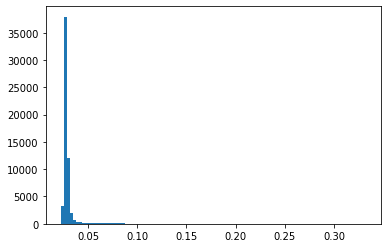

In [15]:
import matplotlib.pyplot as plt
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [16]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [17]:
import pandas as pd
movies = pd.read_csv("./data/ml-25m/movies.csv", index_col="movieId")
print(len(movies))


62423


In [18]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [19]:
movie_ID = 1 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("movies_to_nn[movie_ID]", movies_to_nn[movie_ID])
print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)
print(similar_movies)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
movies_to_nn[movie_ID] 70
Similar movies: 
[ 70  89   0 167  82 159  79  76 260 104]
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
527 Schindler's List (1993) Drama|War
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
356 Forrest Gump (1994) Comedy|Drama|Romance|War
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure


In [20]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass

0
Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
Similar movies: 
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
527 Schindler's List (1993) Drama|War
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
356 Forrest Gump (1994) Comedy|Drama|Romance|War
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure

Query:  Jumanji (1995) Adventure|Children|Fantasy
Similar movies: 
2 Jumanji (1995) Adventure|Children|Fantasy
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
150 Apollo 13 (1995) Adventure|Drama|IMAX
356 Forrest Gump (1994) Comedy|Drama|Romance|War
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
3578 Gladiator (2000) Ac

17 Sense and Sensibility (1995) Drama|Romance
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
318 Shawshank Redemption, The (1994) Crime|Drama
527 Schindler's List (1993) Drama|War
924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
7361 Eternal Sunshine of the Spotless Mind (2004) Drama|Romance|Sci-Fi
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
858 Godfather, The (1972) Crime|Drama

Query:  Four Rooms (1995) Comedy
Similar movies: 
18 Four Rooms (1995) Comedy
4018 What Women Want (2000) Comedy|Romance
4226 Memento (2000) Mystery|Thriller
7254 The Butterfly Effect (2004) Drama|Sci-Fi|Thriller
316 Stargate (1994) Action|Adventure|Sci-Fi
3994 Unbreakable (2000) Drama|Sci-Fi
2716 Ghostbusters (a.k.a. Ghost Busters) (1984) Action|Comedy|Sci-Fi
908 North by Northwest (1959) Action|Adventure|Mystery|Romance|Thriller
3793 X-Men (2000) Action|Adventure|Sci-Fi
4886 Monsters, Inc. (

31 Dangerous Minds (1995) Drama
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
608 Fargo (1996) Comedy|Crime|Drama|Thriller
316 Stargate (1994) Action|Adventure|Sci-Fi
2028 Saving Private Ryan (1998) Action|Drama|War
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
590 Dances with Wolves (1990) Adventure|Drama|Western
2959 Fight Club (1999) Action|Crime|Drama|Thriller
858 Godfather, The (1972) Crime|Drama
3578 Gladiator (2000) Action|Adventure|Drama

Query:  Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
Similar movies: 
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
527 Schindler's List (1993) Drama|War
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
457 Fugitive, The (1993) Thriller
2858 American Beauty (1999) Drama|Romance
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
2959 Fight Club (1999) Action|Crime|Drama|Thri

47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
527 Schindler's List (1993) Drama|War
4226 Memento (2000) Mystery|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1580 Men in Black (a.k.a. MIB) (1997) Action|Comedy|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama

Query:  Pocahontas (1995) Animation|Children|Drama|Musical|Romance
Similar movies: 
48 Pocahontas (1995) Animation|Children|Drama|Musical|Romance
551 Nightmare Before Christmas, The (1993) Animation|Children|Fantasy|Musical
661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
594 Snow White and the Seven Dwarfs (1937) Animation|Children|Drama|Fantasy|Musical
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
1088 Dirty Dancing (1987) Drama|Musical|R

61 Eye for an Eye (1996) Drama|Thriller
805 Time to Kill, A (1996) Drama|Thriller
2023 Godfather: Part III, The (1990) Crime|Drama|Mystery|Thriller
3246 Malcolm X (1992) Drama
69481 Hurt Locker, The (2008) Action|Drama|Thriller|War
168 First Knight (1995) Action|Drama|Romance
1287 Ben-Hur (1959) Action|Adventure|Drama
2427 Thin Red Line, The (1998) Action|Drama|War
8361 Day After Tomorrow, The (2004) Action|Adventure|Drama|Sci-Fi|Thriller
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller

Query:  Mr. Holland's Opus (1995) Drama
Similar movies: 
62 Mr. Holland's Opus (1995) Drama
2858 American Beauty (1999) Drama|Romance
2959 Fight Club (1999) Action|Crime|Drama|Thriller
454 Firm, The (1993) Drama|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
527 Schindler's List (1993) Drama|War
260 Star Wars: Episo

78 Crossing Guard, The (1995) Action|Crime|Drama|Thriller
67923 Fast & Furious (Fast and the Furious 4, The) (2009) Action|Crime|Drama|Thriller
4052 Antitrust (2001) Crime|Drama|Thriller
53129 Mr. Brooks (2007) Crime|Drama|Thriller
6966 Darkman (1990) Action|Crime|Fantasy|Sci-Fi|Thriller
3019 Drugstore Cowboy (1989) Crime|Drama
6187 Life of David Gale, The (2003) Crime|Drama|Thriller
521 Romeo Is Bleeding (1993) Crime|Thriller
996 Last Man Standing (1996) Action|Crime|Drama|Thriller
81 Things to Do in Denver When You're Dead (1995) Crime|Drama|Romance

Query:  Juror, The (1996) Drama|Thriller
Similar movies: 
79 Juror, The (1996) Drama|Thriller
3556 Virgin Suicides, The (1999) Drama|Romance
7438 Kill Bill: Vol. 2 (2004) Action|Drama|Thriller
786 Eraser (1996) Action|Drama|Thriller
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Co

93 Vampire in Brooklyn (1995) Comedy|Horror|Romance
6155 How to Lose a Guy in 10 Days (2003) Comedy|Romance
719 Multiplicity (1996) Comedy
2641 Superman II (1980) Action|Sci-Fi
4299 Knight's Tale, A (2001) Action|Comedy|Romance
419 Beverly Hillbillies, The (1993) Comedy
637 Sgt. Bilko (1996) Comedy
1784 As Good as It Gets (1997) Comedy|Drama|Romance
7 Sabrina (1995) Comedy|Romance
4025 Miss Congeniality (2000) Comedy|Crime

Query:  Beautiful Girls (1996) Comedy|Drama|Romance
Similar movies: 
94 Beautiful Girls (1996) Comedy|Drama|Romance
1285 Heathers (1989) Comedy
224 Don Juan DeMarco (1995) Comedy|Drama|Romance
1042 That Thing You Do! (1996) Comedy|Drama
5377 About a Boy (2002) Comedy|Drama|Romance
2470 Crocodile Dundee (1986) Adventure|Comedy
497 Much Ado About Nothing (1993) Comedy|Romance
3481 High Fidelity (2000) Comedy|Drama|Romance
1358 Sling Blade (1996) Drama
1080 Monty Python's Life of Brian (1979) Comedy

Query:  Broken Arrow (1996) Action|Adventure|Thriller
Similar movies:

109 Headless Body in Topless Bar (1995) Comedy|Drama|Thriller
3867 All the Rage (It's the Rage) (1999) Drama
196753 A Flintstone Family Christmas (1993) (no genres listed)
142628 The Brave Little Toaster to the Rescue (1997) Animation|Children|Comedy
6544 Housekeeper, The (femme de ménage, Une) (2002) Comedy|Drama|Romance
81949 Romantics, The (2010) Comedy|Drama|Romance
158330 The Secret Diaries of Miss Anne Lister (2010) Children|Drama
570 Slingshot, The (Kådisbellan) (1993) Comedy|Drama
2197 Firelight (1997) Drama
406 Federal Hill (1994) Drama

Query:  Braveheart (1995) Action|Drama|War
Similar movies: 
110 Braveheart (1995) Action|Drama|War
457 Fugitive, The (1993) Thriller
527 Schindler's List (1993) Drama|War
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War


126 NeverEnding Story III, The (1994) Adventure|Children|Fantasy
3745 Titan A.E. (2000) Action|Adventure|Animation|Children|Sci-Fi
2422 Karate Kid, Part III, The (1989) Action|Adventure|Children|Drama
68791 Terminator Salvation (2009) Action|Adventure|Sci-Fi|Thriller
56171 Golden Compass, The (2007) Adventure|Children|Fantasy
34319 Island, The (2005) Action|Sci-Fi|Thriller
59501 Chronicles of Narnia: Prince Caspian, The (2008) Adventure|Children|Fantasy
4366 Atlantis: The Lost Empire (2001) Adventure|Animation|Children|Fantasy
63859 Bolt (2008) Action|Adventure|Animation|Children|Comedy
56775 National Treasure: Book of Secrets (2007) Action|Adventure

Query:  Silences of the Palace, The (Saimt el Qusur) (1994) Drama
Similar movies: 
127 Silences of the Palace, The (Saimt el Qusur) (1994) Drama
4528 Off Limits (1988) Action|Thriller|War
763 Last of the High Kings, The (a.k.a. Summer Fling) (1996) Comedy|Drama
44115 Shinobi: Heart Under Blade (2005) Action|Drama|Fantasy|Romance
6432 Cour

141 Birdcage, The (1996) Comedy
153 Batman Forever (1995) Action|Adventure|Comedy|Crime
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
858 Godfather, The (1972) Crime|Drama
356 Forrest Gump (1994) Comedy|Drama|Romance|War
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
527 Schindler's List (1993) Drama|War
2959 Fight Club (1999) Action|Crime|Drama|Thriller
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure

Query:  Shadows (Cienie) (1988) Drama
Similar movies: 
142 Shadows (Cienie) (1988) Drama
6130 Soldier, The (1982) Action
173823 Brain on Fire (2017) Drama
8680 In a Glass Cage (Tras el cristal) (1986) Drama|Horror
136457 Jeff Dunham: Arguing with Myself (2006) Comedy
4764 Kill Me Later (2001) Romance|Thriller
120112 The Grump (2014) Comedy
171315 Sand Castle (2017) Drama|War
4938 Aviator's Wife, The (La femme de l'aviateur) (1981) Drama
4376 Down From the Mountain (2000) Documentary

Query:  Gospa (1995) Drama
Sim

155 Beyond Rangoon (1995) Adventure|Drama|War
1726 Postman, The (1997) Action|Adventure|Drama|Sci-Fi
2450 Howard the Duck (1986) Adventure|Comedy|Sci-Fi
77866 Robin Hood (2010) Action|Adventure|Drama|Romance|War
8640 King Arthur (2004) Action|Adventure|Drama|War
52328 Sunshine (2007) Adventure|Drama|Sci-Fi|Thriller
166635 Passengers (2016) Adventure|Drama|Romance|Sci-Fi
2297 What Dreams May Come (1998) Adventure|Drama|Fantasy|Romance
3285 Beach, The (2000) Adventure|Drama
688 Operation Dumbo Drop (1995) Action|Adventure|Comedy|War

Query:  Blue in the Face (1995) Comedy|Drama
Similar movies: 
156 Blue in the Face (1995) Comedy|Drama
2369 Desperately Seeking Susan (1985) Comedy|Drama|Romance
45672 Click (2006) Adventure|Comedy|Drama|Fantasy|Romance
361 It Could Happen to You (1994) Comedy|Drama|Romance
3448 Good Morning, Vietnam (1987) Comedy|Drama|War
4448 Score, The (2001) Action|Drama
281 Nobody's Fool (1994) Comedy|Drama|Romance
224 Don Juan DeMarco (1995) Comedy|Drama|Romance
1958 

60 Indian in the Cupboard, The (1995) Adventure|Children|Fantasy
56171 Golden Compass, The (2007) Adventure|Children|Fantasy
1371 Star Trek: The Motion Picture (1979) Adventure|Sci-Fi
117529 Jurassic World (2015) Action|Adventure|Drama|Sci-Fi|Thriller
45672 Click (2006) Adventure|Comedy|Drama|Fantasy|Romance

Query:  Hackers (1995) Action|Adventure|Crime|Thriller
Similar movies: 
170 Hackers (1995) Action|Adventure|Crime|Thriller
33166 Crash (2004) Crime|Drama
2000 Lethal Weapon (1987) Action|Comedy|Crime|Drama
953 It's a Wonderful Life (1946) Children|Drama|Fantasy|Romance
353 Crow, The (1994) Action|Crime|Fantasy|Thriller
2002 Lethal Weapon 3 (1992) Action|Comedy|Crime|Drama
4034 Traffic (2000) Crime|Drama|Thriller
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
653 Dragonheart (1996) Action|Adventure|Fantasy
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy

Query:  Jeffrey (1995) Comedy|Drama
Similar movies: 
171 Jeffrey (1995) Co

186 Nine Months (1995) Comedy|Romance
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Action|Drama|Romance
750 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War
2710 Blair Witch Project, The (1999) Drama|Horror|Thriller
1961 Rain Man (1988) Drama
3578 Gladiator (2000) Action|Adventure|Drama
2 Jumanji (1995) Adventure|Children|Fantasy
1208 Apocalypse Now (1979) Action|Drama|War

Query:  Party Girl (1995) Comedy
Similar movies: 
187 Party Girl (1995) Comedy
1592 Air Bud (1997) Children|Comedy
54 Big Green, The (1995) Children|Comedy
1194 Cheech and Chong's Up in Smoke (1978) Comedy
1021 Angels in the Outfield (1994) Children|Comedy
1919 Madeline (1998) Children|Comedy
5942 Hot Chick, The (2002) Comedy
4974 Not Another Teen Movie (2001) Comedy
157 Canadian Bacon (1995) Comedy|War
80860 Life as We Know It (2010) Comedy|Ro

202 Total Eclipse (1995) Drama|Romance
189791 The Book of Masters (2009) Fantasy
165613 Whitney (2015) Drama|Romance
173011 Lost Continent (1951) Sci-Fi
113510 Switch (2011) Action|Crime|Thriller
163751 Shiloh 2: Shiloh Season (1999) Children|Drama
4568 Best of the Best (1989) Action
119950 The Magnificent Trio (1966) Action|Drama|Romance
206050 Popeye the Sailor (1933) Animation
72854 Saga of Gosta Berling, The (Gösta Berlings saga) (1924) Drama|Romance

Query:  To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
Similar movies: 
203 To Wong Foo, Thanks for Everything! Julie Newmar (1995) Comedy
3471 Close Encounters of the Third Kind (1977) Adventure|Drama|Sci-Fi
2797 Big (1988) Comedy|Drama|Fantasy|Romance
53125 Pirates of the Caribbean: At World's End (2007) Action|Adventure|Comedy|Fantasy
5377 About a Boy (2002) Comedy|Drama|Romance
8949 Sideways (2004) Comedy|Drama|Romance
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
1265 Groundhog Day (1993) Co

220 Castle Freak (1995) Horror
5471 Perfect (1985) Drama|Romance
39886 Nine Lives (2005) Drama
178771 Adele Hasn't Had Her Dinner Yet (1978) Comedy|Crime
203206 This Is Not Berlin (2019) Drama
52489 Private Affairs of Bel Ami, The (1947) Drama
192625 Ear Buds: The Podcasting Documentary (2016) Documentary
7882 The Plague of the Zombies (1966) Horror
198641 Assault and Flattery (1956) Animation|Children|Comedy
136437 Clash of Egos (2006) Comedy

221
Query:  Circle of Friends (1995) Drama|Romance
Similar movies: 
222 Circle of Friends (1995) Drama|Romance
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
7361 Eternal Sunshine of the Spotless Mind (2004) Drama|Romance|Sci-Fi
3147 Green Mile, The (1999) Crime|Drama
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Action|Drama|Romance
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
2028 Saving Private Ryan (1998) Act

235 Ed Wood (1994) Comedy|Drama
527 Schindler's List (1993) Drama|War
1704 Good Will Hunting (1997) Drama|Romance
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
1682 Truman Show, The (1998) Comedy|Drama|Sci-Fi
110 Braveheart (1995) Action|Drama|War
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
1961 Rain Man (1988) Drama
2683 Austin Powers: The Spy Who Shagged Me (1999) Action|Adventure|Comedy

Query:  French Kiss (1995) Action|Comedy|Romance
Similar movies: 
236 French Kiss (1995) Action|Comedy|Romance
1961 Rain Man (1988) Drama
1036 Die Hard (1988) Action|Crime|Thriller
457 Fugitive, The (1993) Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
1732 Big Lebowski, The (1998) Comedy|Crime
4973 Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) Comedy|Romance
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
150 Apollo 13 (1995) Adventure|Drama|IMAX

Query:  

251 Hunted, The (1995) Action
27276 Running Out of Time (Am zin) (1999) Action|Crime|Drama|Thriller
123200 Jim Jefferies: I Swear to God (2009) Comedy
153959 4th Man Out (2016) Comedy
162348 The 9th Life of Louis Drax (2016) Mystery|Thriller
117626 Don't Go Near the Water (1957) Adventure|Comedy|Romance
196487 Reign of the Supermen (2019) Action|Animation|Sci-Fi
192791 Replace (2017) Horror|Sci-Fi|Thriller
200678 A Vigilante (2019) Drama|Thriller
142058 The Lorax (1972) Animation|Children

Query:  I.Q. (1994) Comedy|Romance
Similar movies: 
252 I.Q. (1994) Comedy|Romance
457 Fugitive, The (1993) Thriller
858 Godfather, The (1972) Crime|Drama
8636 Spider-Man 2 (2004) Action|Adventure|Sci-Fi|IMAX
109487 Interstellar (2014) Sci-Fi|IMAX
150 Apollo 13 (1995) Adventure|Drama|IMAX
2502 Office Space (1999) Comedy|Crime
1265 Groundhog Day (1993) Comedy|Fantasy|Romance
608 Fargo (1996) Comedy|Crime|Drama|Thriller
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi

Query:  Interview wit

265 Like Water for Chocolate (Como agua para chocolate) (1992) Drama|Fantasy|Romance
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
4896 Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) Adventure|Children|Fantasy
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
515 Remains of the Day, The (1993) Drama|Romance
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
2797 Big (1988) Comedy|Drama|Fantasy|Romance
60069 WALL·E (2008) Adventure|Animation|Children|Romance|Sci-Fi
2028 Saving Private Ryan (1998) Action|Drama|War
1266 Unforgiven (1992) Drama|Western

Query:  Legends of the Fall (1994) Drama|Romance|War|Western
Similar movies: 
266 Legends of the Fall (1994) Drama|Romance|War|Western
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
1201 Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) Action|Adventure|Western
590 Dances with W

282 Nell (1994) Drama
3578 Gladiator (2000) Action|Adventure|Drama
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
2355 Bug's Life, A (1998) Adventure|Animation|Children|Comedy
6711 Lost in Translation (2003) Comedy|Drama|Romance
1961 Rain Man (1988) Drama
1265 Groundhog Day (1993) Comedy|Fantasy|Romance
110 Braveheart (1995) Action|Drama|War

Query:  New Jersey Drive (1995) Crime|Drama
Similar movies: 
283 New Jersey Drive (1995) Crime|Drama
73386 Staten Island (2009) Crime|Drama
8448 ComDads (les Compères) (1983) Comedy|Crime
5583 Devil Bat, The (1940) Crime|Horror|Mystery|Sci-Fi
8742 Night Patrol (1984) Comedy
7768 Guncrazy (1992) Crime|Drama|Romance|Thriller
88593 Yellow Sea, The (a.k.a. The Murderer) (Hwanghae) (2010) Crime|Drama|Thriller
38188 Bubble (2006) Crime|Drama|Mystery
134629 Flight World War II (2015) Action|Sci-Fi|War
2909 Fi

299 Priest (1994) Drama
2455 Fly, The (1986) Drama|Horror|Sci-Fi|Thriller
1586 G.I. Jane (1997) Action|Drama
72641 Blind Side, The  (2009) Drama
105 Bridges of Madison County, The (1995) Drama|Romance
491 Man Without a Face, The (1993) Drama
3409 Final Destination (2000) Drama|Thriller
30749 Hotel Rwanda (2004) Drama|War
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
3157 Stuart Little (1999) Children|Comedy|Fantasy

Query:  Quiz Show (1994) Drama
Similar movies: 
300 Quiz Show (1994) Drama
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
110 Braveheart (1995) Action|Drama|War
1721 Titanic (1997) Drama|Romance
150 Apollo 13 (1995) Adventure|Drama|IMAX
457 Fugitive, The (1993) Thriller
4973 Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) Comedy|Romance
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
2329 American History X (1998) Crime|Drama
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventur

317 Santa Clause, The (1994) Comedy|Drama|Fantasy
356 Forrest Gump (1994) Comedy|Drama|Romance|War
3578 Gladiator (2000) Action|Adventure|Drama
2997 Being John Malkovich (1999) Comedy|Drama|Fantasy
79132 Inception (2010) Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
110 Braveheart (1995) Action|Drama|War
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy

Query:  Shawshank Redemption, The (1994) Crime|Drama
Similar movies: 
318 Shawshank Redemption, The (1994) Crime|Drama
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2959 Fight Club (1999) Action|Crime|Drama|Thriller
527 Schindler's List (1993) Drama|War
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ar

333 Tommy Boy (1995) Comedy
1265 Groundhog Day (1993) Comedy|Fantasy|Romance
527 Schindler's List (1993) Drama|War
750 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War
3578 Gladiator (2000) Action|Adventure|Drama
457 Fugitive, The (1993) Thriller
1080 Monty Python's Life of Brian (1979) Comedy
858 Godfather, The (1972) Crime|Drama
110 Braveheart (1995) Action|Drama|War
223 Clerks (1994) Comedy

Query:  Vanya on 42nd Street (1994) Drama
Similar movies: 
334 Vanya on 42nd Street (1994) Drama
3984 Diamonds Are Forever (1971) Action|Adventure|Thriller
41569 King Kong (2005) Action|Adventure|Drama|Fantasy|Thriller
1916 Buffalo '66 (a.k.a. Buffalo 66) (1998) Drama|Romance
1801 Man in the Iron Mask, The (1998) Action|Adventure|Drama
68791 Terminator Salvation (2009) Action|Adventure|Sci-Fi|Thriller
122892 Avengers: Age of Ultron (2015) Action|Adventure|Sci-Fi
46723 Babel (2006) Drama|Thriller
3168 Easy Rider (1969) Adventure|Drama
34437 Broken Flowers (20

350 Client, The (1994) Drama|Mystery|Thriller
3578 Gladiator (2000) Action|Adventure|Drama
1221 Godfather: Part II, The (1974) Crime|Drama
527 Schindler's List (1993) Drama|War
2959 Fight Club (1999) Action|Crime|Drama|Thriller
1089 Reservoir Dogs (1992) Crime|Mystery|Thriller
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
2858 American Beauty (1999) Drama|Romance
858 Godfather, The (1972) Crime|Drama

Query:  Corrina, Corrina (1994) Comedy|Drama|Romance
Similar movies: 
351 Corrina, Corrina (1994) Comedy|Drama|Romance
2145 Pretty in Pink (1986) Comedy|Drama|Romance
6218 Bend It Like Beckham (2002) Comedy|Drama|Romance
2797 Big (1988) Comedy|Drama|Fantasy|Romance
1358 Sling Blade (1996) Drama
19 Ace Ventura: When Nature Calls (1995) Comedy
52973 Knocked Up (2007) Comedy|Drama|Romance
1193 One Flew Over the Cuckoo's Nest (1975) Drama
5377 About a Boy (2002) Comedy|Drama|Romance
2054 Honey, I Shrunk the Kids (1989) Adventure|Children

364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
595 Beauty and the Beast (1991) Animation|Children|Fantasy|Musical|Romance|IMAX
356 Forrest Gump (1994) Comedy|Drama|Romance|War
150 Apollo 13 (1995) Adventure|Drama|IMAX
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
527 Schindler's List (1993) Drama|War
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical

Query:  Little Buddha (1993) Drama
Similar movies: 
365 Little Buddha (1993) Drama
2140 Dark Crystal, The (1982) Adventure|Fantasy
3798 What Lies Beneath (2000) Drama|Horror|Mystery
2336 Elizabeth (1998) Drama
1027 Robin Hood: Prince of Thieves (1991) Adventure|Drama
2761 Iron Giant, The (1999) Adventure|Animation|Children|Drama|Sci-Fi
4720 Others, The (2001) D

379 Timecop (1994) Action|Sci-Fi|Thriller
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
44191 V for Vendetta (2006) Action|Sci-Fi|Thriller|IMAX
6539 Pirates of the Caribbean: The Curse of the Black Pearl (2003) Action|Adventure|Comedy|Fantasy
1320 Alien³ (a.k.a. Alien 3) (1992) Action|Horror|Sci-Fi|Thriller
60069 WALL·E (2008) Adventure|Animation|Children|Romance|Sci-Fi
786 Eraser (1996) Action|Drama|Thriller
91529 Dark Knight Rises, The (2012) Action|Adventure|Crime|IMAX
2 Jumanji (1995) Adventure|Children|Fantasy
2028 Saving Private Ryan (1998) Action|Drama|War

Query:  True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
Similar movies: 
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
527 Schindler's List (1993) Drama|War
356 Forrest Gump (1994) Comedy|Drama|Romance|War
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
2959 Fight Club (1999) Action|Crime|Drama|Thriller
587 Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
3147 Green M

393 Street Fighter (1994) Action|Adventure|Fantasy
1587 Conan the Barbarian (1982) Action|Adventure|Fantasy
2193 Willow (1988) Action|Adventure|Fantasy
8810 AVP: Alien vs. Predator (2004) Action|Horror|Sci-Fi|Thriller
7373 Hellboy (2004) Action|Adventure|Fantasy|Horror
68791 Terminator Salvation (2009) Action|Adventure|Sci-Fi|Thriller
1049 Ghost and the Darkness, The (1996) Action|Adventure
5171 Time Machine, The (2002) Action|Adventure|Sci-Fi
3704 Mad Max Beyond Thunderdome (1985) Action|Adventure|Sci-Fi
4367 Lara Croft: Tomb Raider (2001) Action|Adventure

Query:  Coldblooded (1995) Comedy
Similar movies: 
394 Coldblooded (1995) Comedy
56945 Perfect Holiday, The (2007) Comedy|Romance
2999 Man of the Century (1999) Comedy
794 Midnight Dancers (Sibak) (1994) Comedy|Drama
6312 Private Function, A (1984) Comedy
119 Steal Big, Steal Little (1995) Comedy
4100 Disorderlies (1987) Comedy
91866 Beneath the Darkness (2011) Thriller
62788 Lost Boys: The Tribe (2008) Comedy|Horror|Thriller
83096

6196 Cradle 2 the Grave (2003) Action|Crime|Drama|Thriller
101137 Dead Man Down (2013) Action|Crime|Drama|Romance|Thriller
6797 Bugsy (1991) Crime|Drama
4410 Something Wild (1986) Comedy|Crime|Drama
5888 Brother (Brat) (1997) Crime|Drama

Query:  Addams Family Values (1993) Children|Comedy|Fantasy
Similar movies: 
410 Addams Family Values (1993) Children|Comedy|Fantasy
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
527 Schindler's List (1993) Drama|War
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
457 Fugitive, The (1993) Thriller
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
110 Braveheart (1995) Action|Drama|War
1222 Full Metal Jacket (1987) Drama|War
6377 Finding Nemo (2003) Adventure|Animation|Children|Comedy
3147 Green Mile, The (1999) Crime|Drama

Query:  Martin Lawrence: You So Crazy (1994) Comedy|Documentary
Similar movies: 
411 Martin Lawrence: You So Crazy (1994) Comedy|Documentary
86721 Idiots and Angels (2008) A

427 Boxing Helena (1993) Drama|Mystery|Romance|Thriller
2505 8MM (1999) Drama|Mystery|Thriller
2009 Soylent Green (1973) Drama|Mystery|Sci-Fi|Thriller
57368 Cloverfield (2008) Action|Mystery|Sci-Fi|Thriller
517 Rising Sun (1993) Action|Drama|Mystery
4874 K-PAX (2001) Drama|Fantasy|Mystery|Sci-Fi
533 Shadow, The (1994) Action|Adventure|Fantasy|Mystery
7347 Secret Window (2004) Mystery|Thriller
2803 Pelican Brief, The (1993) Crime|Drama|Mystery|Romance|Thriller
2316 Practical Magic (1998) Drama|Fantasy|Mystery|Romance

Query:  Bronx Tale, A (1993) Drama
Similar movies: 
428 Bronx Tale, A (1993) Drama
2997 Being John Malkovich (1999) Comedy|Drama|Fantasy
5995 Pianist, The (2002) Drama|War
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
587 Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
3753 Patriot, The (2000) Action|Dr

442 Demolition Man (1993) Action|Adventure|Sci-Fi
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
2858 American Beauty (1999) Drama|Romance
1214 Alien (1979) Horror|Sci-Fi
527 Schindler's List (1993) Drama|War
457 Fugitive, The (1993) Thriller
1580 Men in Black (a.k.a. MIB) (1997) Action|Comedy|Sci-Fi
377 Speed (1994) Action|Romance|Thriller
541 Blade Runner (1982) Action|Sci-Fi|Thriller

Query:  Endless Summer 2, The (1994) Adventure|Documentary
Similar movies: 
443 Endless Summer 2, The (1994) Adventure|Documentary
86279 Into Eternity (2010) Documentary
104272 Blackfish (2013) Documentary
115901 Wedding Video, The (2012) Comedy
69503 Going Berserk (1983) Comedy
189111 Spiral (2018) Documentary
5914 Vernon, Florida (1981) Documentary
190187 The Graduation (2017) Documentary
145978 Batkid Begins (2015) Children|Documentary
97866 Imposter, The (2012) Documentary

Query:  Even Cowgirls Get the Blues (1993) Comedy|Romance
Sim

459 Getaway, The (1994) Action|Adventure|Crime|Drama|Romance|Thriller
78 Crossing Guard, The (1995) Action|Crime|Drama|Thriller
69640 Public Enemies (2009) Crime|Drama|Thriller
4052 Antitrust (2001) Crime|Drama|Thriller
37720 Exorcism of Emily Rose, The (2005) Crime|Drama|Horror|Thriller
2912 Limey, The (1999) Crime|Drama|Thriller
42 Dead Presidents (1995) Action|Crime|Drama
53129 Mr. Brooks (2007) Crime|Drama|Thriller
5108 John Q (2002) Crime|Drama|Thriller
96861 Taken 2 (2012) Action|Crime|Drama|Thriller

Query:  Getting Even with Dad (1994) Comedy
Similar movies: 
460 Getting Even with Dad (1994) Comedy
7701 Look Who's Talking Too (1990) Comedy|Romance
3786 But I'm a Cheerleader (1999) Comedy
505 North (1994) Comedy
174 Jury Duty (1995) Comedy
48982 Flushed Away (2006) Animation|Comedy
4091 Can't Buy Me Love (1987) Comedy|Romance
68952 Drag Me to Hell (2009) Comedy|Horror
5303 Joe Versus the Volcano (1990) Comedy|Romance
274 Man of the House (1995) Comedy

Query:  Go Fish (1994) Dra

474 In the Line of Fire (1993) Action|Thriller
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
318 Shawshank Redemption, The (1994) Crime|Drama
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
1721 Titanic (1997) Drama|Romance
110 Braveheart (1995) Action|Drama|War
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
7361 Eternal Sunshine of the Spotless Mind (2004) Drama|Romance|Sci-Fi
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
457 Fugitive, The (1993) Thriller

Query:  In the Name of the Father (1993) Drama
Similar movies: 
475 In the Name of the Father (1993) Drama
356 Forrest Gump (1994) Comedy|Drama|Romance|War
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Action|Drama|Romance
3578 Gladiator (2000) Action|Adventure|Drama
2028 Saving Private Ryan (1998) Action|Dram

488 M. Butterfly (1993) Drama|Romance
134103 Blackbird (2007) Drama
176659 Средь бела дня... (1982) Drama
176625 Message from the King (2017) Thriller
209041 Yamasong: March of the Hollows (2017) Animation|Fantasy
174589 Porn in the Hood (2012) Comedy
179283 The Criminal Quartet (1989) Action|Adventure|Crime
107752 White Fang (Zanna Bianca) (1973) Adventure
159219 Mission to Lars (2011) Documentary
145901 Bullshot (1983) Adventure|Comedy

Query:  Made in America (1993) Comedy
Similar movies: 
489 Made in America (1993) Comedy
2657 Rocky Horror Picture Show, The (1975) Comedy|Horror|Musical|Sci-Fi
342 Muriel's Wedding (1994) Comedy
5377 About a Boy (2002) Comedy|Drama|Romance
3087 Scrooged (1988) Comedy|Fantasy|Romance
76251 Kick-Ass (2010) Action|Comedy
3552 Caddyshack (1980) Comedy
1569 My Best Friend's Wedding (1997) Comedy|Romance
4734 Jay and Silent Bob Strike Back (2001) Adventure|Comedy
4015 Dude, Where's My Car? (2000) Comedy|Sci-Fi

Query:  Malice (1993) Thriller
Similar movies

506 Orlando (1992) Drama|Fantasy|Romance
118696 The Hobbit: The Battle of the Five Armies (2014) Adventure|Fantasy
137857 The Jungle Book (2016) Adventure|Drama|Fantasy
3153 7th Voyage of Sinbad, The (1958) Action|Adventure|Fantasy
27790 Millions (2004) Children|Comedy|Crime|Drama|Fantasy
6093 Last Unicorn, The (1982) Animation|Children|Fantasy
95558 Beasts of the Southern Wild (2012) Drama|Fantasy
7123 Naked Lunch (1991) Drama|Fantasy|Mystery|Sci-Fi
48082 Science of Sleep, The (La science des rêves) (2006) Comedy|Drama|Fantasy|Romance
139855 Anomalisa (2015) Animation|Comedy|Fantasy

Query:  Perfect World, A (1993) Crime|Drama|Thriller
Similar movies: 
507 Perfect World, A (1993) Crime|Drama|Thriller
1589 Cop Land (1997) Action|Crime|Drama|Thriller
23 Assassins (1995) Action|Crime|Thriller
7160 Monster (2003) Crime|Drama
53972 Live Free or Die Hard (2007) Action|Adventure|Crime|Thriller
1754 Fallen (1998) Crime|Drama|Fantasy|Thriller
3735 Serpico (1973) Crime|Drama
5464 Road to Perdit

521 Romeo Is Bleeding (1993) Crime|Thriller
23 Assassins (1995) Action|Crime|Thriller
2986 RoboCop 2 (1990) Action|Crime|Sci-Fi|Thriller
7367 Ladykillers, The (2004) Comedy|Crime
2389 Psycho (1998) Crime|Horror|Thriller
58295 Bank Job, The (2008) Action|Crime|Thriller
48877 Saw III (2006) Crime|Horror|Thriller
55577 Saw IV (2007) Crime|Horror|Thriller
4351 Point Break (1991) Action|Crime|Thriller
2380 Police Academy 3: Back in Training (1986) Comedy|Crime

Query:  Romper Stomper (1992) Action|Drama
Similar movies: 
522 Romper Stomper (1992) Action|Drama
991 Michael Collins (1996) Drama
89774 Warrior (2011) Drama
5066 Walk to Remember, A (2002) Drama|Romance
1015 Homeward Bound: The Incredible Journey (1993) Adventure|Children|Drama
2412 Rocky V (1990) Action|Drama
537 Sirens (1994) Drama
1088 Dirty Dancing (1987) Drama|Musical|Romance
2409 Rocky II (1979) Action|Drama
1615 Edge, The (1997) Adventure|Drama

Query:  Ruby in Paradise (1993) Drama
Similar movies: 
523 Ruby in Paradise (199

540 Sliver (1993) Thriller
73017 Sherlock Holmes (2009) Action|Crime|Mystery|Thriller
903 Vertigo (1958) Drama|Mystery|Romance|Thriller
8636 Spider-Man 2 (2004) Action|Adventure|Sci-Fi|IMAX
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
2329 American History X (1998) Crime|Drama
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
1653 Gattaca (1997) Drama|Sci-Fi|Thriller
5618 Spirited Away (Sen to Chihiro no kamikakushi) (2001) Adventure|Animation|Fantasy
6378 Italian Job, The (2003) Action|Crime

Query:  Blade Runner (1982) Action|Sci-Fi|Thriller
Similar movies: 
541 Blade Runner (1982) Action|Sci-Fi|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Roman

555 True Romance (1993) Crime|Thriller
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
2997 Being John Malkovich (1999) Comedy|Drama|Fantasy
2028 Saving Private Ryan (1998) Action|Drama|War
1219 Psycho (1960) Crime|Horror
1208 Apocalypse Now (1979) Action|Drama|War
924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror

Query:  War Room, The (1993) Documentary
Similar movies: 
556 War Room, The (1993) Documentary
7256 Touching the Void (2003) Adventure|Documentary
581 Celluloid Closet, The (1995) Documentary
1189 Thin Blue Line, The (1988) Documentary
6380 Capturing the Friedmans (2003) Documentary
34072 March of the Penguins (Marche de l'empereur, La) (2005) Documentary
143385 Bridge of Spies (2015) Drama|Thriller
54881 King of Kong, The (2007)

577 Andre (1994) Adventure|Children|Drama
125197 That’s What She Said (2012) Comedy
126166 Lightspeed (2006) Action|Fantasy|Sci-Fi
154967 Skyscraper (1996) Action|Adventure
179831 Terrarium (2003) Sci-Fi
299 Priest (1994) Drama
190091 Kid Auto Races at Venice (1914) Comedy
200420 Orcs! (2011) Action|Horror
51834 Becoming Jane (2007) Drama|Romance
158141 Pao's Story (2006) Drama

578
Query:  Escort, The (Scorta, La) (1993) Crime|Thriller
Similar movies: 
579 Escort, The (Scorta, La) (1993) Crime|Thriller
820 Death in the Garden (Mort en ce jardin, La) (1956) Drama
4837 Cruising (1980) Crime|Drama|Thriller
8395 Last of Sheila, The (1973) Crime|Mystery|Thriller
4988 White Water Summer (1987) Adventure
5285 Lucky Break (2001) Comedy|Crime
96401 Je, tu, il, elle (I, You, He, She) (1976) Drama
1659 Hurricane Streets (1997) Drama
8290 Mitchell (1975) Action|Crime
70423 A Time to Live, a Time to Die (1985) Drama

Query:  Princess Caraboo (1994) Drama
Similar movies: 
580 Princess Caraboo (1994

598 Window to Paris (Okno v Parizh) (1994) Comedy|Fantasy
170046 Amy Schumer: The Leather Special (2017) Comedy
107354 Good Ol' Freda (2013) Documentary
142082 The Nightmare (2015) Documentary
158402 The Crew (2016) Action
172587 Vacations in Prostokvashino (1980) Animation
141810 Autumn Marathon (1979) Comedy|Drama
167038 Dear Zindagi (2016) Drama|Romance
404 Brother Minister: The Assassination of Malcolm X (1994) Documentary
96563 Paradise Lost 3: Purgatory (2011) Documentary

Query:  Wild Bunch, The (1969) Adventure|Western
Similar movies: 
599 Wild Bunch, The (1969) Adventure|Western
4327 Magnificent Seven, The (1960) Adventure|Western
1254 Treasure of the Sierra Madre, The (1948) Action|Adventure|Drama|Western
82459 True Grit (2010) Western
3037 Little Big Man (1970) Western
128360 The Hateful Eight (2015) Western
1209 Once Upon a Time in the West (C'era una volta il West) (1968) Action|Drama|Western
2951 Fistful of Dollars, A (Per un pugno di dollari) (1964) Action|Western
3508 O

612 Pallbearer, The (1996) Comedy
281 Nobody's Fool (1994) Comedy|Drama|Romance
58998 Forgetting Sarah Marshall (2008) Comedy|Romance
89864 50/50 (2011) Comedy|Drama
8910 I Heart Huckabees (2004) Comedy
3979 Little Nicky (2000) Comedy
67087 I Love You, Man (2009) Comedy
4161 Mexican, The (2001) Action|Comedy
159093 Now You See Me 2 (2016) Action|Comedy|Thriller
2369 Desperately Seeking Susan (1985) Comedy|Drama|Romance

Query:  Jane Eyre (1996) Drama|Romance
Similar movies: 
613 Jane Eyre (1996) Drama|Romance
1120 People vs. Larry Flynt, The (1996) Comedy|Drama
193 Showgirls (1995) Drama
1357 Shine (1996) Drama|Romance
33660 Cinderella Man (2005) Drama|Romance
8464 Super Size Me (2004) Comedy|Documentary|Drama
3967 Billy Elliot (2000) Drama
1228 Raging Bull (1980) Drama
2353 Enemy of the State (1998) Action|Thriller
1266 Unforgiven (1992) Drama|Western

Query:  Loaded (1994) Drama|Thriller
Similar movies: 
614 Loaded (1994) Drama|Thriller
118085 Welcome, or No Trespassing (1964) Childr

635 Family Thing, A (1996) Comedy|Drama
106766 Inside Llewyn Davis (2013) Drama
95088 Safety Not Guaranteed (2012) Comedy|Drama
1895 Can't Hardly Wait (1998) Comedy|Drama|Romance
5364 Unfaithful (2002) Drama|Thriller
55830 Be Kind Rewind (2008) Comedy
89864 50/50 (2011) Comedy|Drama
51935 Shooter (2007) Action|Drama|Thriller
1300 My Life as a Dog (Mitt liv som hund) (1985) Comedy|Drama
1297 Real Genius (1985) Comedy

Query:  Frisk (1995) Drama
Similar movies: 
636 Frisk (1995) Drama
190743 Support the Girls (2018) Drama
4530 Permanent Record (1988) Drama
173535 The Adventures of Sherlock Holmes and Doctor Watson: The Hunt for the Tiger (1980) (no genres listed)
198145 The Perfect Date Romance
6895 Normal (2003) Drama
176499 It Happened in Broad Daylight (1958) Crime|Thriller
134945 Police Story 2013 (2013) Action|Crime|Drama|Thriller
176073 The Incredible Jessica James (2017) Comedy|Romance
2998 Dreaming of Joseph Lees (1999) Drama|Romance

Query:  Sgt. Bilko (1996) Comedy
Similar movi

657 Yankee Zulu (1994) Comedy|Drama
8025 The Thief (1997) Drama
4375 Adventures of Felix, The (a.k.a. Funny Felix) (Drôle de Félix) (2000) Comedy|Drama
7775 Thin Blue Lie, The (2000) Drama
98587 Caesar Must Die (Cesare deve morire) (2012) Drama
193041 One Cut of the Dead (2017) Comedy|Horror
129739 Bogowie (2014) Drama
27646 Soldier's Girl (2003) Drama
4416 Day the Earth Caught Fire, The (1961) Sci-Fi
6245 Sweet Charity (1969) Comedy|Drama|Musical|Romance

Query:  Billy's Holiday (1995) Drama|Musical
Similar movies: 
658 Billy's Holiday (1995) Drama|Musical
7282 Hip Hop Witch, Da (2000) Comedy|Horror|Thriller
8971 Veer Zaara (2004) Drama|Musical|Romance
2604 Let it Come Down: The Life of Paul Bowles (1998) Documentary
192109 Minding the Gap (2018) Documentary
4829 Lady in a Cage (1964) Drama|Thriller
31894 ChubbChubbs!, The (2002) Animation|Comedy|Sci-Fi
141830 Unbelievable Adventures of Italians in Russia (1974) Adventure|Comedy
27163 Something Is Happening (Kuch Kuch Hota Hai) (1998)

679 Run of the Country, The (1995) Drama
8537 Kaena: The Prophecy (Kaena: La prophétie) (2003) Action|Adventure|Animation|Children|Sci-Fi
108569 Monkey's Paw, The (2013) Horror|Thriller
146006 High Rollers (1976) Comedy|Crime
151515 My King (2015) Drama|Romance
4051 Horrors of Spider Island (Ein Toter Hing im Netz) (1960) Horror|Sci-Fi
7585 Summertime (1955) Drama|Romance
183197 Dave Chappelle: Equanimity (2017) Comedy
26189 I Love You, Alice B. Toklas! (1968) Comedy
1558 Sudden Manhattan (1997) Comedy

Query:  Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
Similar movies: 
680 Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
27904 Scanner Darkly, A (2006) Animation|Drama|Mystery|Sci-Fi|Thriller
182715 Annihilation (2018) Adventure|Mystery|Sci-Fi|Thriller
27788 Jacket, The (2005) Drama|Mystery|Sci-Fi|Thriller
113741 Coherence (2013) Drama|Mystery|Sci-Fi|Thriller
17641

702 Faces (1968) Drama
98996 Filming 'Othello' (1978) Documentary
199354 Uncertain Terms (2014) Drama
122274 Pumpkinhead IV: Blood Feud (2007) Horror
127315 Alien Outpost (2014) Action|Sci-Fi|Thriller
179419 Shoes (1916) Drama
149408 Mobile Suit Gundam F91 (1991) Animation|Sci-Fi
64645 The Wrecking Crew (1968) Action|Adventure|Comedy|Crime|Drama|Thriller
122264 Knights (1993) Action|Adventure|Sci-Fi
188327 Neobyknovennyy Match (1955) Animation

Query:  Boys (1996) Drama
Similar movies: 
703 Boys (1996) Drama
26142 Major Dundee (1965) Adventure|War|Western
5200 Man Who Saw Tomorrow, The (1980) Documentary
76772 Carne (1991) Drama|Thriller
4538 Salome's Last Dance (1988) Comedy|Drama
185443 Ricky Gervais: Humanity (2018) Comedy
5592 Monster in the Closet (1986) Comedy|Horror
175755 The Double Lover (2017) Thriller
33316 Bridge, The (Brücke, Die) (1959) Drama|War
144468 Faith of My Fathers (2005) Documentary|Drama

Query:  Quest, The (1996) Action|Adventure
Similar movies: 
704 Quest, The

722 Haunted World of Edward D. Wood Jr., The (1996) Documentary
79832 Easy Living (1937) Comedy|Romance
170407 Alibi.com (2017) Comedy
207103 The Other Side (2014) Drama|Horror|Thriller
101717 Elusive Summer of '68, The (Varljivo leto '68) (1984) Comedy|Drama|Romance
190525 Ramen Shop (2018) Drama
176937 Jigsaw (2017) Horror|Thriller
6780 Brief History of Time, A (1991) Documentary
147008 In Bar (2007) Drama
205909 Your Next Life (2004) Drama

Query:  Two Friends (1986) Drama
Similar movies: 
723 Two Friends (1986) Drama
1314 Breathing Room (1996) Romance
94675 Three Steps Above Heaven (2010) Drama|Romance
8921 Rose Tattoo, The (1955) Drama|Romance
142628 The Brave Little Toaster to the Rescue (1997) Animation|Children|Comedy
8290 Mitchell (1975) Action|Crime
77264 Ballet Shoes (2007) Children|Drama
159970 Never Back Down: No Surrender (2016) Action|Drama
47525 Lie with Me (2005) Drama|Romance
7774 My Side of the Mountain (1969) Adventure|Children

Query:  Craft, The (1996) Drama|Fanta

744 Brothers in Trouble (1995) Drama
4868 Bangkok Dangerous (2000) Action|Crime|Romance
139775 I Am Big Bird: The Caroll Spinney Story (2014) Documentary
2831 A Dog of Flanders (1999) Children|Drama
183437 World of Tomorrow Episode Two: The Burden of Other People's Thoughts (2017) Animation|Sci-Fi
166020 Dog Eat Dog (2016) Crime|Drama|Thriller
183855 Terminal Drama|Thriller
175981 Twelve Angry Men (1954) Drama
139584 Pokémon Ranger and the Temple of the Sea (2006) Animation|Children
8290 Mitchell (1975) Action|Crime

Query:  Wallace & Gromit: A Close Shave (1995) Animation|Children|Comedy
Similar movies: 
745 Wallace & Gromit: A Close Shave (1995) Animation|Children|Comedy
1148 Wallace & Gromit: The Wrong Trousers (1993) Animation|Children|Comedy|Crime
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
2080 Lady and the Tramp (1955) Animation|Children|Comedy|Romance
134853 Inside Out (2015) Adventure|Animation|Children|Comedy|Drama|Fantasy
5218 Ice Age (2002) Adventure

758 Jar, The (Khomreh) (1992) Drama
160209 The Resurrection of Jake the Snake (2015) Documentary
86279 Into Eternity (2010) Documentary
84781 Notorious Landlady, The (1962) Comedy|Mystery
55078 Far from the Madding Crowd (1967) Drama|Romance
127228 The Referees (2009) Documentary
111314 Into the Storm (2009) Drama|War
104631 Adore (2013) Drama|Romance
197909 Fyre Fraud (2019) Documentary
3085 Living Dead Girl, The (Morte Vivante, La) (1982) Horror

Query:  Maya Lin: A Strong Clear Vision (1994) Documentary
Similar movies: 
759 Maya Lin: A Strong Clear Vision (1994) Documentary
59731 Bigger, Stronger, Faster* (2008) Documentary
176423 Icarus (2017) Documentary
6125 Secret Policeman's Other Ball, The (1982) Comedy|Documentary|Musical
76738 Steam of Life (Miesten vuoro) (2010) Documentary
144360 The Midnight After (2014) Comedy|Sci-Fi|Thriller
164917 13th (2016) Documentary
30892 In the Realms of the Unreal (2004) Animation|Documentary
91888 Chico & Rita (2010) Animation|Musical|Romance
8

778 Trainspotting (1996) Comedy|Crime|Drama
356 Forrest Gump (1994) Comedy|Drama|Romance|War
527 Schindler's List (1993) Drama|War
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
2959 Fight Club (1999) Action|Crime|Drama|Thriller
2858 American Beauty (1999) Drama|Romance
1704 Good Will Hunting (1997) Drama|Romance
858 Godfather, The (1972) Crime|Drama

Query:  'Til There Was You (1997) Drama|Romance
Similar movies: 
779 'Til There Was You (1997) Drama|Romance
167814 A Wedding (2017) (no genres listed)
136740 Bedtime for Bonzo (1951) Comedy
144286 A Good Man (2014) Action
128882 The Outsider (1983) Action|Crime|Drama|Thriller
130040 Mo (1983) Horror
88603 Change of Address (Changement d'adresse) (2006) Comedy
123715 The Munsters' Revenge (1981) (no genres listed)
148054 Passage de Venus (1874) Documentary
91169 Easier with Practice (2009) Drama|Romance

Query:  Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Th

792 Hungarian Fairy Tale, A (Hol volt, hol nem volt) (1987) Fantasy
8649 Gray Lady Down (1978) Drama|Thriller
96520 Prime Suspect: The Lost Child (1995) Drama|Mystery
66140 Blackout (2007) Horror|Thriller
6706 Taking Sides (2001) Drama
855 Every Other Weekend (Un week-end sur deux) (1990) Drama
32124 God Is Brazilian (Deus É Brasileiro) (2003) Adventure|Comedy|Fantasy
123288 Taken (2002) Sci-Fi
118085 Welcome, or No Trespassing (1964) Children|Comedy
160187 Blackway (2015) Thriller

Query:  My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
Similar movies: 
793 My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
8728 Creeping Flesh, The (1973) Horror|Sci-Fi
97966 Bait (2012) Action|Horror|Thriller
26288 Dracula (1973) Horror
141818 Ordinary Miracle (1978) Comedy|Drama|Fantasy|Romance
104883 Conspiracy, The (2012) Horror|Thriller
8290 Mitchell (1975) Action|Crime
5659 Rocking Horse Winner, The (1950) Drama|Horror
109781 Were

806 American Buffalo (1996) Crime|Drama
6989 Gorky Park (1983) Crime|Drama|Thriller
37382 Domino (2005) Crime|Drama|Thriller
6291 Lilya 4-Ever (Lilja 4-ever) (2002) Crime|Drama
67923 Fast & Furious (Fast and the Furious 4, The) (2009) Action|Crime|Drama|Thriller
82744 Faster (2010) Action|Crime|Drama
4218 River's Edge (1986) Crime|Drama
149 Amateur (1994) Crime|Drama|Thriller
694 Substitute, The (1996) Action|Crime|Drama
60647 Transsiberian (2008) Crime|Drama|Thriller

Query:  Rendezvous in Paris (Rendez-vous de Paris, Les) (1995) Comedy|Romance
Similar movies: 
807 Rendezvous in Paris (Rendez-vous de Paris, Les) (1995) Comedy|Romance
141816 12 Chairs (1976) Adventure|Comedy
4311 Bloody Angels (1732 Høtten: Marerittet har et postnummer) (1998) Thriller
5129 Big Bad Love (2001) Drama
98975 Antiviral (2012) Horror|Sci-Fi|Thriller
31260 Boys Town (1938) Drama
82131 Men in War (1957) Drama|War
32862 With Six You Get Eggroll (1968) Comedy|Romance
108289 Flight 93 (2006) Drama
5592 Monster i

828 Adventures of Pinocchio, The (1996) Adventure|Children
2279 Urban Legend (1998) Horror|Thriller
59501 Chronicles of Narnia: Prince Caspian, The (2008) Adventure|Children|Fantasy
53121 Shrek the Third (2007) Adventure|Animation|Children|Comedy|Fantasy
1015 Homeward Bound: The Incredible Journey (1993) Adventure|Children|Drama
2116 Lord of the Rings, The (1978) Adventure|Animation|Children|Fantasy
3745 Titan A.E. (2000) Action|Adventure|Animation|Children|Sci-Fi
4232 Spy Kids (2001) Action|Adventure|Children|Comedy
711 Flipper (1996) Adventure|Children
6889 Brother Bear (2003) Adventure|Animation|Children

Query:  Joe's Apartment (1996) Comedy|Fantasy|Musical
Similar movies: 
829 Joe's Apartment (1996) Comedy|Fantasy|Musical
2088 Popeye (1980) Adventure|Comedy|Musical
1256 Duck Soup (1933) Comedy|Musical|War
1381 Grease 2 (1982) Comedy|Musical|Romance
2746 Little Shop of Horrors (1986) Comedy|Horror|Musical
6296 Mighty Wind, A (2003) Comedy|Musical
2394 Prince of Egypt, The (1998) An

842 Tales from the Crypt Presents: Bordello of Blood (1996) Comedy|Horror
3821 Nutty Professor II: The Klumps (2000) Comedy
4015 Dude, Where's My Car? (2000) Comedy|Sci-Fi
8910 I Heart Huckabees (2004) Comedy
135 Down Periscope (1996) Comedy
969 African Queen, The (1951) Adventure|Comedy|Romance|War
3979 Little Nicky (2000) Comedy
3552 Caddyshack (1980) Comedy
5449 Mr. Deeds (2002) Comedy|Romance
4545 Short Circuit (1986) Comedy|Sci-Fi

Query:  Lotto Land (1995) Drama
Similar movies: 
843 Lotto Land (1995) Drama
129773 Soulless (2012) Comedy|Drama
41941 Aura, The (Aura, El) (2005) Crime|Drama|Thriller
171647 Pink Floyd: Live at Pompeii (1972) Documentary
175981 Twelve Angry Men (1954) Drama
6190 Lawless Heart, The (2003) Comedy|Drama
5494 Earth Trembles, The (Terra trema: Episodio del mare, La) (1948) Drama
206208 Bill Burr: Paper Tiger (2019) Comedy
2777 Cobra (1925) Drama
8995 Patsy, The (1964) Comedy

Query:  Story of Xinghua, The (Xinghua san yue tian) (1994) Drama
Similar movies: 

864 Wife, The (1995) Comedy|Drama
32864 Move Over, Darling (1963) Comedy|Romance
6899 Alien from L.A. (1988) Sci-Fi
71490 Grace (2009) Drama|Horror|Thriller
141050 Theeb (2014) Adventure|Drama|Thriller
141818 Ordinary Miracle (1978) Comedy|Drama|Fantasy|Romance
4300 Bread and Roses (2000) Drama
796 Very Natural Thing, A (1974) Drama
183831 The Lodgers (2017) Horror
7821 Ice-Cold in Alex (1958) Adventure|Drama|War

Query:  Small Faces (1996) Drama
Similar movies: 
865 Small Faces (1996) Drama
44041 All Quiet on the Western Front (1979) Action|Drama|War
101079 Kiss Me (Kyss Mig) (2011) Drama|Romance
6641 Code Unknown (Code inconnu: Récit incomplet de divers voyages) (2000) Drama
84834 Three Kingdoms: Resurrection of the Dragon (Saam gwok dzi gin lung se gap) (2008) Action|Drama|War
175981 Twelve Angry Men (1954) Drama
135498 Once Upon a Time in High School (2004) Action|Drama|Romance
98570 Peace, Love & Misunderstanding (2011) Drama|Romance
79910 According to Greta (2009) Drama|Romance
5

885 Bogus (1996) Children|Drama|Fantasy
176413 Bliss (2012) Drama
151739 Dirty Grandpa (2016) Comedy
38 It Takes Two (1995) Children|Comedy
179267 The Big Brass Ring (1999) Drama|Thriller
4477 Big Top Pee-Wee (1988) Adventure|Children|Comedy
178549 No Big Deal (1983) (no genres listed)
58105 Spiderwick Chronicles, The (2008) Adventure|Children|Drama|Fantasy|IMAX
131058 Santa's Apprentice (2010) Animation|Children
200896 Son of Samson (1960) Action|Adventure|Drama|Romance

Query:  Bulletproof (1996) Action|Comedy|Crime
Similar movies: 
886 Bulletproof (1996) Action|Comedy|Crime
97306 Seven Psychopaths (2012) Comedy|Crime
2379 Police Academy 2: Their First Assignment (1985) Comedy|Crime
134368 Spy (2015) Action|Comedy|Crime
6548 Bad Boys II (2003) Action|Comedy|Crime|Thriller
104241 Kick-Ass 2 (2013) Action|Comedy|Crime
7325 Starsky & Hutch (2004) Action|Comedy|Crime|Thriller
6893 Italian Job, The (1969) Action|Comedy|Crime
7004 Kindergarten Cop (1990) Action|Comedy|Crime|Thriller
861 Su

906 Gaslight (1944) Drama|Thriller
678 Some Folks Call It a Sling Blade (1993) Drama|Thriller
1253 Day the Earth Stood Still, The (1951) Drama|Sci-Fi|Thriller
1719 Sweet Hereafter, The (1997) Drama
4235 Amores Perros (Love's a Bitch) (2000) Drama|Thriller
3152 Last Picture Show, The (1971) Drama
115569 Nightcrawler (2014) Crime|Drama|Thriller
5878 Talk to Her (Hable con Ella) (2002) Drama|Romance
3196 Stalag 17 (1953) Drama|War
28 Persuasion (1995) Drama|Romance

Query:  Gay Divorcee, The (1934) Comedy|Musical|Romance
Similar movies: 
907 Gay Divorcee, The (1934) Comedy|Musical|Romance
1066 Shall We Dance (1937) Comedy|Musical|Romance
901 Funny Face (1957) Comedy|Musical
1083 Great Race, The (1965) Comedy|Musical
96588 Pitch Perfect (2012) Comedy|Musical
3606 On the Town (1949) Comedy|Musical|Romance
2946 Help! (1965) Comedy|Musical
6183 Pillow Talk (1959) Comedy|Musical|Romance
4356 Gentlemen Prefer Blondes (1953) Comedy|Musical|Romance
2083 Muppet Christmas Carol, The (1992) Children

920 Gone with the Wind (1939) Drama|Romance|War
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Action|Drama|Romance
110 Braveheart (1995) Action|Drama|War
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
318 Shawshank Redemption, The (1994) Crime|Drama
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
6377 Finding Nemo (2003) Adventure|Animation|Children|Comedy
4878 Donnie Darko (2001) Drama|Mystery|Sci-Fi|Thriller
527 Schindler's List (1993) Drama|War

Query:  My Favorite Year (1982) Comedy
Similar movies: 
921 My Favorite Year (1982) Comedy
4701 Rush Hour 2 (2001) Action|Comedy
3869 Naked Gun 2 1/2: The Smell of Fear, The (1991) Comedy
3988 How the Grinch Stole Christmas (a.k.a. The Grinch) (2000) Children|Comedy|Fantasy
88 Black Sheep (1996) Comedy
4890 Shallow Hal (2001) Comedy|Fantasy|Romance
2150 Gods Must Be Crazy, The (1980) Adventure|Comedy
6659 Tremors (1990) Comedy

934 Father of the Bride (1950) Comedy
2150 Gods Must Be Crazy, The (1980) Adventure|Comedy
3752 Me, Myself & Irene (2000) Adventure|Comedy
135 Down Periscope (1996) Comedy
3988 How the Grinch Stole Christmas (a.k.a. The Grinch) (2000) Children|Comedy|Fantasy
2406 Romancing the Stone (1984) Action|Adventure|Comedy|Romance
5673 Punch-Drunk Love (2002) Comedy|Drama|Romance
3489 Hook (1991) Adventure|Comedy|Fantasy
3882 Bring It On (2000) Comedy
3948 Meet the Parents (2000) Comedy

Query:  Band Wagon, The (1953) Comedy|Musical
Similar movies: 
935 Band Wagon, The (1953) Comedy|Musical
6296 Mighty Wind, A (2003) Comedy|Musical
1066 Shall We Dance (1937) Comedy|Musical|Romance
2946 Help! (1965) Comedy|Musical
8796 Funny Thing Happened on the Way to the Forum, A (1966) Comedy|Musical
1083 Great Race, The (1965) Comedy|Musical
8542 Day at the Races, A (1937) Comedy|Musical
4356 Gentlemen Prefer Blondes (1953) Comedy|Musical|Romance
3061 Holiday Inn (1942) Comedy|Musical
56805 Walk Hard: The De

948 Giant (1956) Drama|Romance|Western
2070 Tender Mercies (1983) Drama|Romance|Western
3508 Outlaw Josey Wales, The (1976) Action|Adventure|Drama|Thriller|Western
3681 For a Few Dollars More (Per qualche dollaro in più) (1965) Action|Drama|Thriller|Western
3871 Shane (1953) Drama|Western
1209 Once Upon a Time in the West (C'era una volta il West) (1968) Action|Drama|Western
3365 Searchers, The (1956) Drama|Western
1283 High Noon (1952) Drama|Western
7027 Silverado (1985) Action|Western
3494 True Grit (1969) Adventure|Drama|Western

Query:  East of Eden (1955) Drama
Similar movies: 
949 East of Eden (1955) Drama
1962 Driving Miss Daisy (1989) Drama
45447 Da Vinci Code, The (2006) Drama|Mystery|Thriller
3107 Backdraft (1991) Action|Drama
2871 Deliverance (1972) Adventure|Drama|Thriller
48780 Prestige, The (2006) Drama|Mystery|Sci-Fi|Thriller
5377 About a Boy (2002) Comedy|Drama|Romance
3698 Running Man, The (1987) Action|Sci-Fi
5618 Spirited Away (Sen to Chihiro no kamikakushi) (2001) A

968 Night of the Living Dead (1968) Horror|Sci-Fi|Thriller
109487 Interstellar (2014) Sci-Fi|IMAX
5618 Spirited Away (Sen to Chihiro no kamikakushi) (2001) Adventure|Animation|Fantasy
1653 Gattaca (1997) Drama|Sci-Fi|Thriller
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
8636 Spider-Man 2 (2004) Action|Adventure|Sci-Fi|IMAX
91500 The Hunger Games (2012) Action|Adventure|Drama|Sci-Fi|Thriller
161 Crimson Tide (1995) Drama|Thriller|War
2355 Bug's Life, A (1998) Adventure|Animation|Children|Comedy
7147 Big Fish (2003) Drama|Fantasy|Romance

Query:  African Queen, The (1951) Adventure|Comedy|Romance|War
Similar movies: 
969 African Queen, The (1951) Adventure|Comedy|Romance|War
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy
1073 Willy Wonka & the Chocolate Factory (1971) Children|Comedy|Fantasy|Musical
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
2355 Bug

108149 At Berkeley (2013) Documentary
194200 Hell Fest (2018) Horror

Query:  Grace of My Heart (1996) Comedy|Drama
Similar movies: 
988 Grace of My Heart (1996) Comedy|Drama
198925 Dead Cert (2010) Action|Horror|Thriller
90719 J. Edgar (2011) Drama
3392 She-Devil (1989) Comedy
141424 Eskimo (1933) Drama
4600 Gross Anatomy (a.k.a. A Cut Above) (1989) Comedy|Drama
169296 Queen of Spades: The Dark Rite (2015) Horror
69609 Holly (2006) Drama
101222 Elevator (2011)  Thriller
205827 Fanatic (2019) Thriller

Query:  Brother of Sleep (Schlafes Bruder) (1995) Drama
Similar movies: 
989 Brother of Sleep (Schlafes Bruder) (1995) Drama
130506 Berserk: The Golden Age Arc 2 - The Battle for Doldrey (2012) Action|Animation|Fantasy
2588 Cloudland (1998) Animation
5362 White Fang 2: Myth of the White Wolf (1994) Adventure|Children
192109 Minding the Gap (2018) Documentary
27497 Lost Battalion, The (2001) Action|Drama|War
8540 Back to Bataan (1945) Drama|War
136204 The Second Mother (2015) Drama
135753

In [21]:
data = torch.load('../movie_lens_dlrm_v4/top_model.out.pt')

In [22]:
data['weight'].shape

torch.Size([1, 128])

In [23]:
torch.load('../movie_lens_dlrm_v4/bottom_model.mlp.pt')['weights'][1].shape

torch.Size([128, 128])

In [24]:
torch.load('.././movie_lens_dlrm_v4-no-cpp-mlp/bottom_model.mlp.pt')['weights'][0].shape

torch.Size([128, 171])